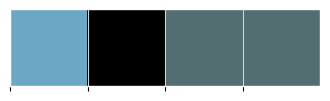

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.tsa.stattools
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose


from src.model_utils import feature_engineering, time_split, time_split_plot  # Importa a função feature_engineering do arquivo model_utils.py em src


# Warnings filtering.
import warnings
warnings.filterwarnings('ignore')

# Visualization Settings
%matplotlib inline

mpl.style.use('ggplot')

mpl.rcParams['figure.figsize']      = (20, 5)
mpl.rcParams['figure.titlesize']    = 25
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['font.size']           = 12
mpl.rcParams['axes.grid']           = True
# mpl.rcParams['figure.dpi']          = 150

import xgboost as xgb

# Palette Seting
palette = ['#6CA7C5', '#000000', '#526E70', '#526E70']
palette2 = ['#214737', '#083313']

sns.set_palette(sns.color_palette(palette))
sns.palplot(sns.color_palette(palette))


In [2]:
df = pd.read_csv('input/train.csv')

In [3]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df.set_index('date', inplace=True)
df.sort_values(by=['date', 'store', 'item'], inplace=True)
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,1,2,33
2013-01-01,1,3,15
2013-01-01,1,4,10
2013-01-01,1,5,11


In [5]:
series = df['sales']

In [6]:
df.head(30)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,1,2,33
2013-01-01,1,3,15
2013-01-01,1,4,10
2013-01-01,1,5,11
2013-01-01,1,6,31
2013-01-01,1,7,25
2013-01-01,1,8,33
2013-01-01,1,9,18


In [7]:
def time_feature(df):
    
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
        
        df = df.copy()
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['dayofyear'] = df.index.dayofyear
        df['dayofmonth'] = df.index.day
        df['weekofyear'] = df.index.isocalendar().week

        return df

In [8]:
time_feature(df)

,store,item,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,
2013-01-01,1,1,13,0,1,1,1,2013,1,1,1
2013-01-01,1,2,33,0,1,1,1,2013,1,1,1
2013-01-01,1,3,15,0,1,1,1,2013,1,1,1
2013-01-01,1,4,10,0,1,1,1,2013,1,1,1
2013-01-01,1,5,11,0,1,1,1,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,70,0,6,4,12,2017,365,31,52
2017-12-31,10,47,22,0,6,4,12,2017,365,31,52
2017-12-31,10,48,60,0,6,4,12,2017,365,31,52


## Analise de estacionaridade

Uma série temporal é considerada estacionária se suas propriedades estatísticas fundamentais (como média e variância) permanecem constantes ao longo do tempo. Isso significa que não há tendências sistemáticas de crescimento ou declínio, e a volatilidade dos dados não muda significativamente em diferentes períodos.

A estacionariedade é um pressuposto crucial para muitos modelos de análise de séries temporais. Se uma série não for estacionária, as previsões e inferências estatísticas podem ser imprecisas e enganosas.

Teste de Dickey-Fuller Aumentado (ADF): Este teste verifica a presença de uma raiz unitária na série, o que indica não estacionariedade. A hipótese nula do teste é que a série possui uma raiz unitária (ou seja, não é estacionária). Se o valor-p do teste for menor que um nível de significância predefinido (geralmente 0,05), rejeitamos a hipótese nula e concluímos que a série é estacionária.

Teste KPSS: Ao contrário dos testes ADF e PP, o teste KPSS tem como hipótese nula que a série é estacionária. Se o valor-p do teste for maior que o nível de significância, não rejeitamos a hipótese nula e concluímos que a série é estacionária.

In [9]:
kpss=statsmodels.tsa.stattools.kpss(series)

In [10]:
print(f'estatistica do teste: {kpss[0]}')
print(f'P-valor: {kpss[1]}')


estatistica do teste: 38.625477463568565
P-valor: 0.01


In [11]:
df.to_csv('sales.csv')

## Ruido branco e autocorrelação 
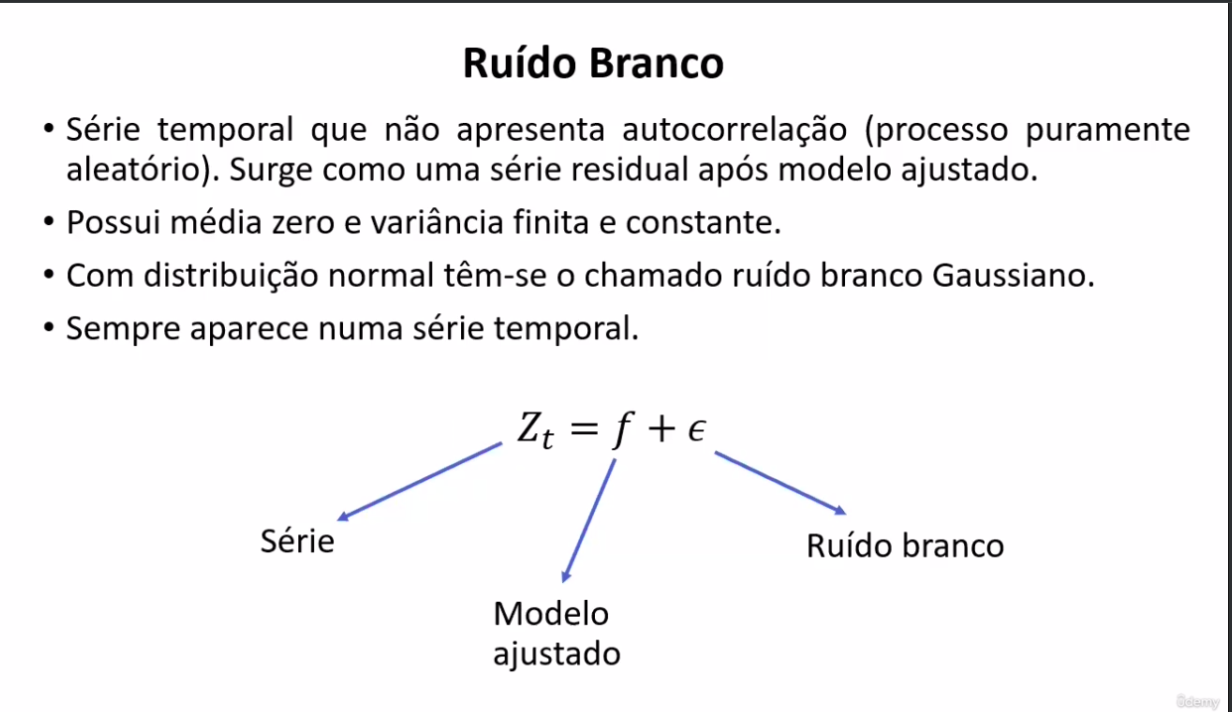

In [12]:
data_limit = '2017-09-30'
train, test = time_split(df, data_limit)
print(f'Train shape: {train.shape}. Train data goes from {train.index.min()} to {train.index.max()}.')
print(f'Test shape: {test.shape}. Train data goes from {test.index.min()} to {test.index.max()}.')

Train shape: (866500, 3). Train data goes from 2013-01-01 00:00:00 to 2017-09-29 00:00:00.
Test shape: (46500, 3). Train data goes from 2017-09-30 00:00:00 to 2017-12-31 00:00:00.


In [13]:
train

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,1,2,33
2013-01-01,1,3,15
2013-01-01,1,4,10
2013-01-01,1,5,11
...,...,...,...
2017-09-29,10,46,77
2017-09-29,10,47,35
2017-09-29,10,48,71


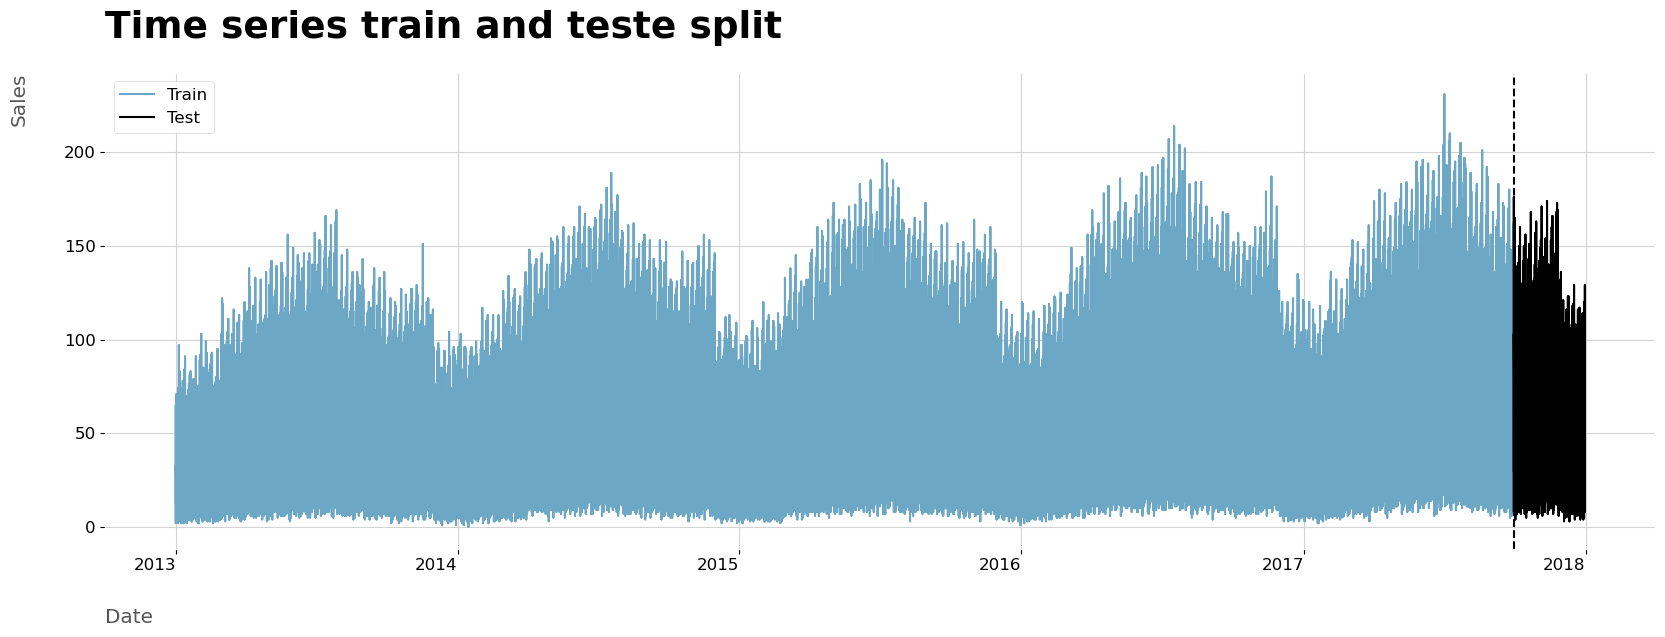

In [14]:
time_split_plot(train, test, data_limit)

# Decomposição de Séries Temporais

## Tendência (Trend)
A tendência refere-se ao movimento de longo prazo na série temporal. Ela pode ser crescente, decrescente ou estável. A tendência captura o comportamento subjacente da série ao longo do tempo, ignorando as variações de curto prazo. Alguns exemplos de tendências incluem:

Crescente: As vendas de um produto que aumentam consistentemente ao longo de vários anos.

Decrescente: O número de assinantes de um serviço que diminui continuamente.

Estável: Um nível de vendas que se mantém relativamente constante ao longo do tempo.

## Sazonalidade (Seasonality)
A sazonalidade refere-se aos padrões ou flutuações que se repetem em intervalos regulares ao longo do tempo, geralmente dentro de um ano. Estes padrões são previsíveis e ocorrem devido a fatores como estações do ano, feriados ou eventos específicos. Exemplos de sazonalidade incluem:

Anual: Aumento nas vendas de brinquedos durante a temporada de Natal.

Mensal: Flutuações nas vendas de roupas devido às mudanças de estação (verão, inverno, etc.).

Semanal: Picos nas vendas de produtos alimentícios durante os finais de semana.

## Ciclos (Cycles)
Os ciclos referem-se a flutuações mais longas que não são de natureza sazonal e podem ocorrer em intervalos irregulares. Eles são frequentemente influenciados por fatores econômicos, políticos ou outros eventos externos. Os ciclos são mais difíceis de prever porque não têm um período fixo como a sazonalidade. Exemplos de ciclos incluem:

Ciclo Econômico: Períodos de expansão e recessão econômica que afetam as vendas de várias indústrias.

Ciclos de Negócios: Flutuações no desempenho de uma empresa devido a estratégias de negócios, mudanças na administração ou novos lançamentos de produtos.


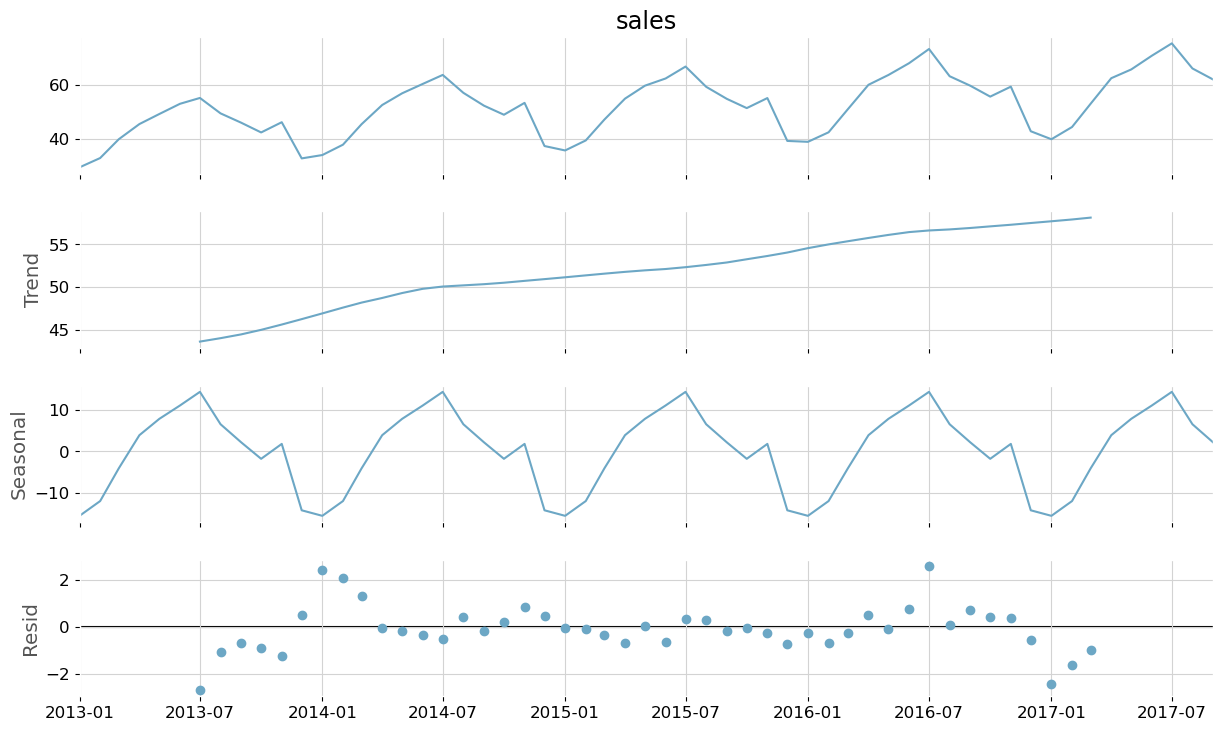

In [15]:
week_avg = train["sales"].resample("MS").mean().interpolate()

decomposição = seasonal_decompose(week_avg, model="additive")

fig = decomposição.plot()
fig.set_size_inches(12,8)
plt.show()

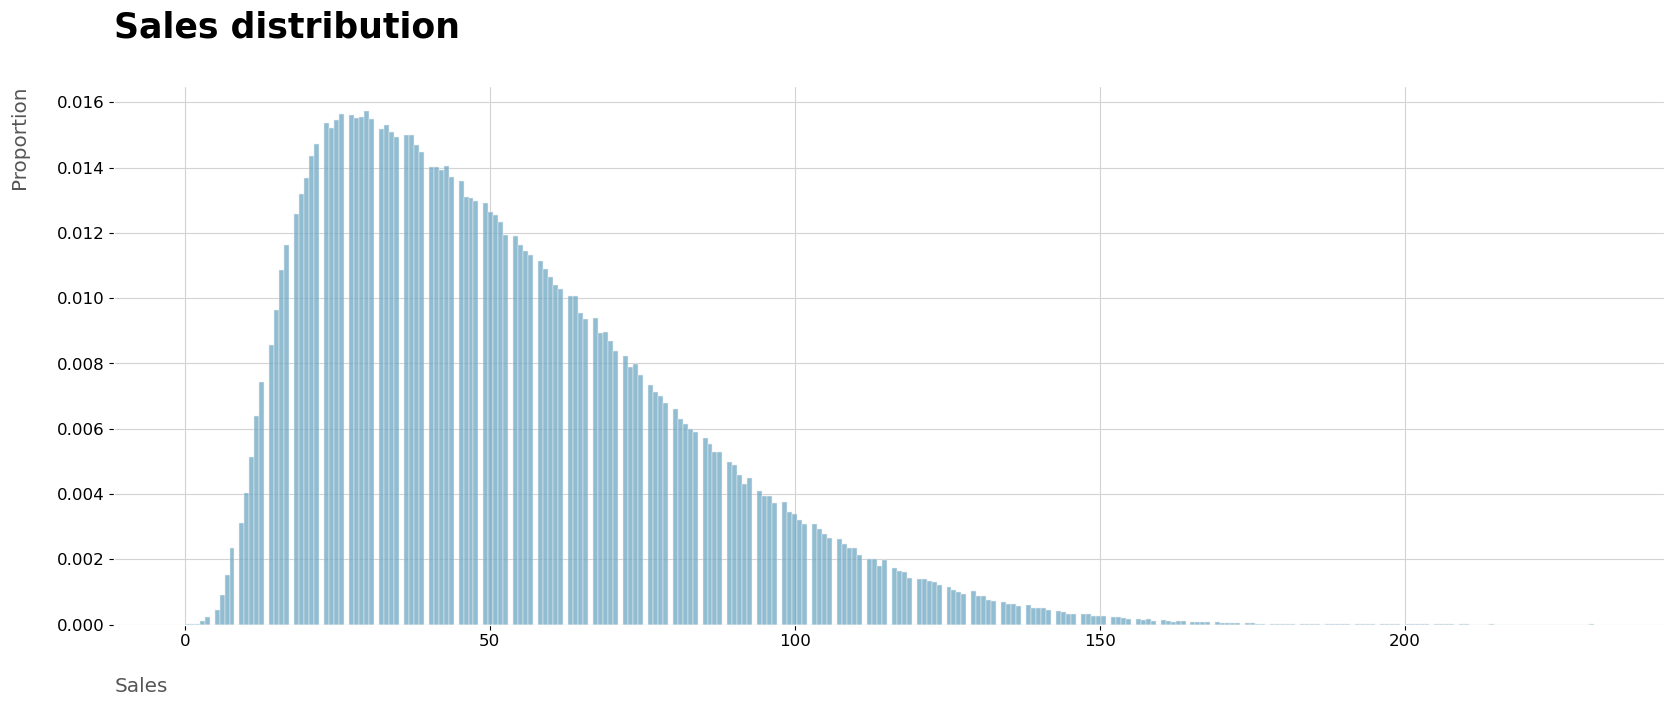

In [16]:
plt.figure(figsize=(20, 7))
sns.histplot(data=train, x='sales', stat='proportion')
plt.title('Sales distribution', loc='left', pad=35, fontsize=25, fontweight='bold')
plt.xlabel('Sales', loc='left', labelpad=20)
plt.ylabel('Proportion', loc='top', labelpad=20)
plt.show()